In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from copy import deepcopy

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, \
    classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler


In [48]:
df_save = pd.read_csv('./data/dataset_lab1.csv', sep=',')
df = deepcopy(df_save)

In [49]:
df.drop('URL', axis=1, inplace=True)

In [50]:
df.CHARSET.unique()

array(['iso-8859-1', 'UTF-8', 'us-ascii', 'ISO-8859-1', 'utf-8', nan,
       'windows-1251', 'ISO-8859', 'windows-1252'], dtype=object)

In [51]:
# filtering CHARSET
df = df[df.CHARSET.notna()]
df.CHARSET = df.CHARSET.apply(lambda x: x.lower())
counts = df['CHARSET'].value_counts()
counts = counts[counts > 1]
df = df.query('CHARSET in @counts.keys()')

In [52]:
# drop rows with no servers
df = df[df.SERVER.notna()]

In [53]:
df.drop('CONTENT_LENGTH', axis=1, inplace=True)

In [54]:
df.drop(['WHOIS_COUNTRY',
         'WHOIS_STATEPRO',
         'APP_BYTES',
         'APP_PACKETS',
         'WHOIS_REGDATE',
         'WHOIS_UPDATED_DATE'], axis=1, inplace=True)

In [55]:
df = df[df.DNS_QUERY_TIMES.notna()]

In [56]:
servers = df.SERVER.value_counts()
servers = servers[servers > 10]
servers_list = tuple(servers.index.to_list())


def my_server(_server):
    return _server if _server in servers_list else 'other'

In [57]:
df.SERVER = df.SERVER.apply(my_server)

In [58]:
df

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,Type
0,16,7,iso-8859-1,nginx,7,0,2,9,10,1153,832,2.0,1
1,16,6,utf-8,other,17,7,4,17,19,1265,1230,0.0,0
2,16,6,us-ascii,Microsoft-HTTPAPI/2.0,0,0,0,0,0,0,0,0.0,0
3,17,6,iso-8859-1,nginx,31,22,3,39,37,18784,4380,8.0,0
5,18,7,utf-8,nginx,11,6,9,11,13,838,894,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,194,16,utf-8,Apache,0,0,0,0,3,186,0,0.0,1
1777,198,17,utf-8,Apache,0,0,0,0,2,124,0,0.0,1
1778,201,34,utf-8,other,83,2,6,87,89,132181,6945,4.0,0
1779,234,34,iso-8859-1,cloudflare-nginx,0,0,0,0,0,0,0,0.0,0


In [59]:
sc = StandardScaler()
columns_to_standardize = [x for x in df.columns.tolist() if x not in ['CHARSET', 'SERVER', 'Type']]

scaled = sc.fit_transform(df[columns_to_standardize])
df[columns_to_standardize] = scaled

In [60]:
columns_to_dummy = ['CHARSET', 'SERVER']

In [61]:
for col in columns_to_dummy:
    encoded = pd.get_dummies(df[col])
    for enc_col in encoded.columns:
        df[f'{col}_{enc_col}'] = encoded[enc_col]
df.drop(columns_to_dummy, axis=1, inplace=True)

<Axes: >

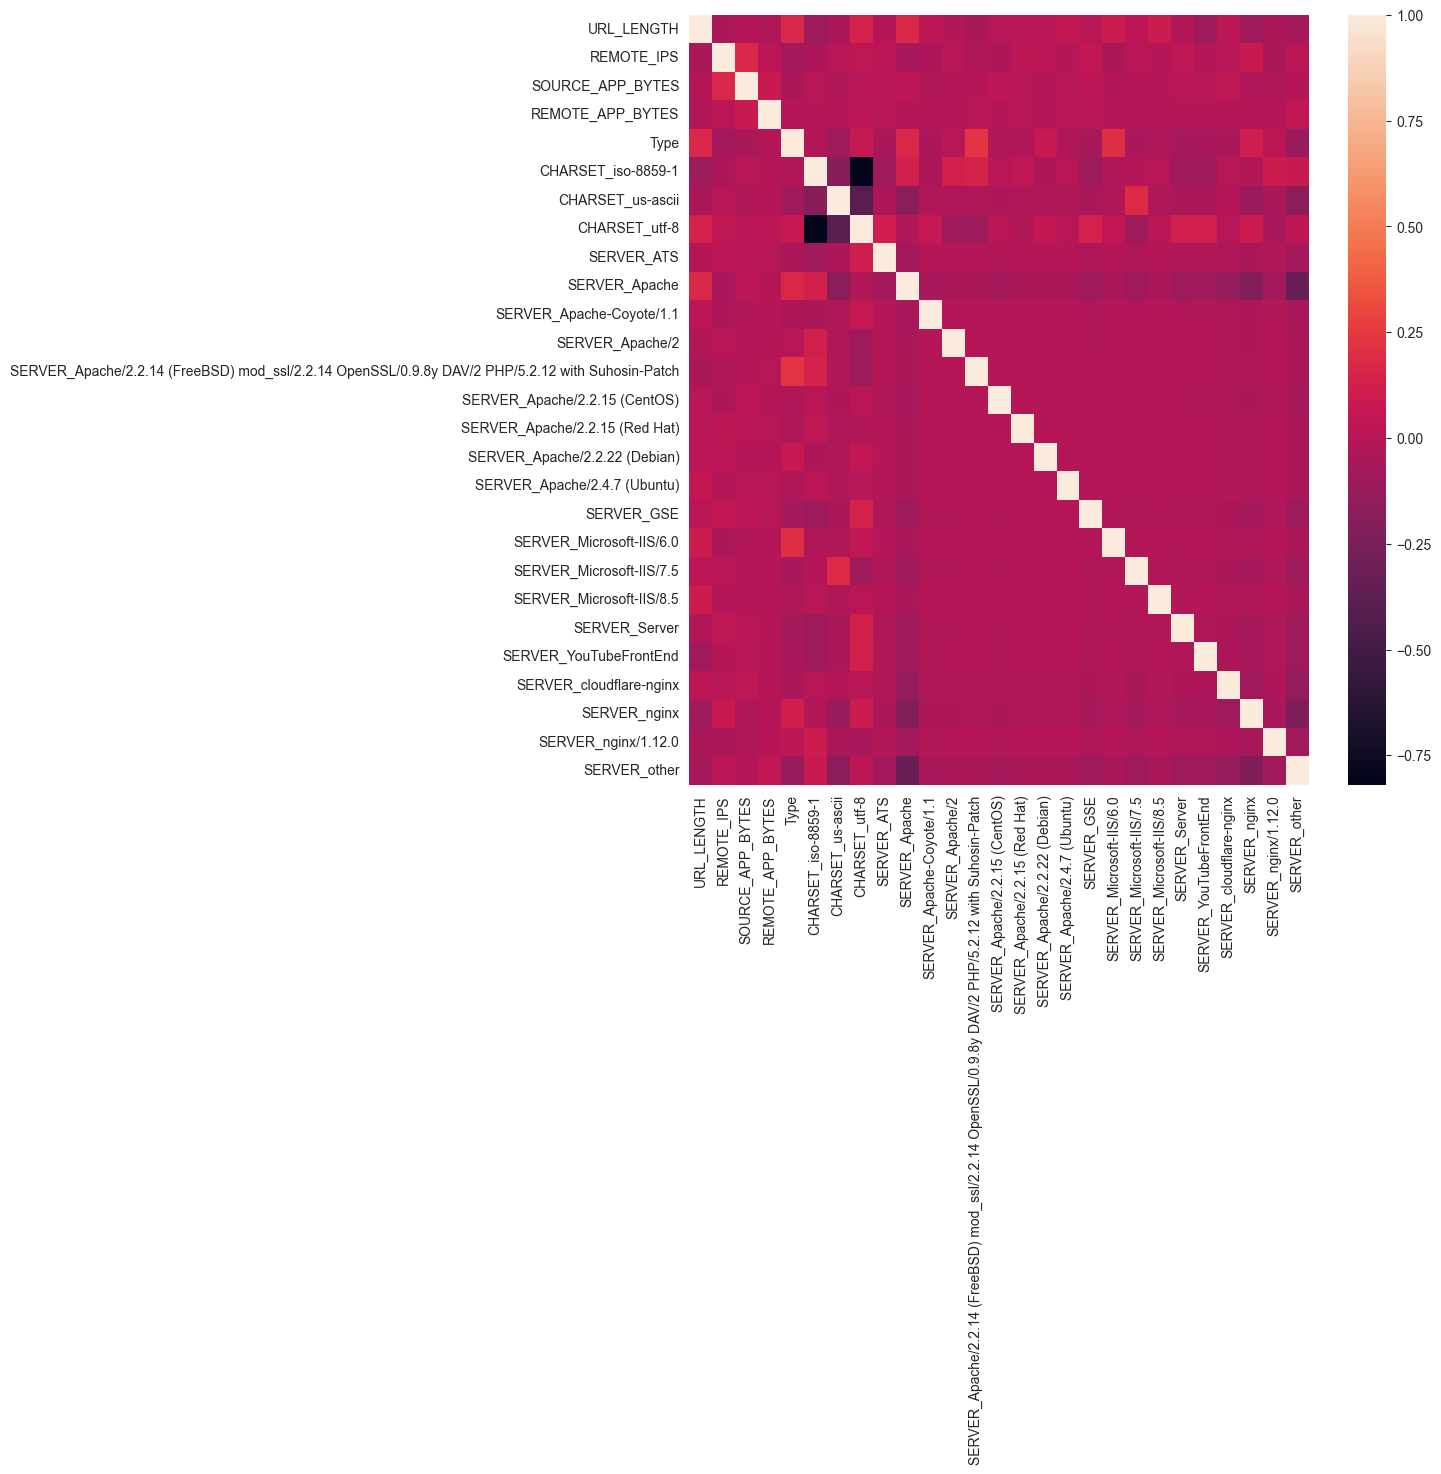

In [74]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.drop(['SERVER_Microsoft-HTTPAPI/2.0',
                     'SOURCE_APP_PACKETS',
                     'REMOTE_APP_PACKETS',
                     'REMOTE_APP_PACKETS',
                     'TCP_CONVERSATION_EXCHANGE',
                     'NUMBER_SPECIAL_CHARACTERS',
                     'DIST_REMOTE_TCP_PORT',
                     'DNS_QUERY_TIMES',
                     ], axis=1).corr())


In [109]:
ready_data = df.drop(['SERVER_Microsoft-HTTPAPI/2.0',
                      'SOURCE_APP_PACKETS',
                      'REMOTE_APP_PACKETS',
                      'REMOTE_APP_PACKETS',
                      'TCP_CONVERSATION_EXCHANGE',
                      'NUMBER_SPECIAL_CHARACTERS',
                      'DIST_REMOTE_TCP_PORT',
                      'DNS_QUERY_TIMES',
                      ], axis=1)
ready_data['Type'] = np.abs(ready_data['Type'] - 1)

TRAIN

In [145]:
Y = ready_data['Type'].to_numpy()
X = ready_data.drop(columns=['Type']).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=np.random.randint(100))

In [111]:
def plot_confusion_matrix_and_print_metrics(y_pred, y_true, model_params, model_name=""):
    conf_matrix = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(conf_matrix , annot=True, annot_kws={"size": 16}, fmt="d")
    if model_name:
        ax.set_title(f"Evaluation Results for {model_name} model with parameters {model_params}", fontsize=14, pad=20)
    ax.set_xlabel("Predicted Values", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(['Benign', 'Malicious'])
    ax.set_ylabel("Actual Values", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(['Benign', 'Malicious'])
    plt.show()

    print(classification_report(y_true, y_pred))

def train_and_evaluate_model(model_name):
    model_class, model_params = MODEL_CLASSES_AND_PARAMETERS[model_name]
    model = model_class(**model_params)
    model.fit(X_train, Y_train)
    y_test_pred = model.predict(X_test)
    plot_confusion_matrix_and_print_metrics(y_test_pred, Y_test, model_params, model_name)
    print("\n"*5)

In [112]:
MODEL_CLASSES_AND_PARAMETERS = {
    # https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
    "NAIVE_BAYES": (GaussianNB,
                    {"priors": None, "var_smoothing": 1e-09}),

    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    "LOGISTIC_REGRESSION": (LogisticRegression,
                            {"random_state": 0, "class_weight": None, "solver": "lbfgs", "max_iter": 100}),
}

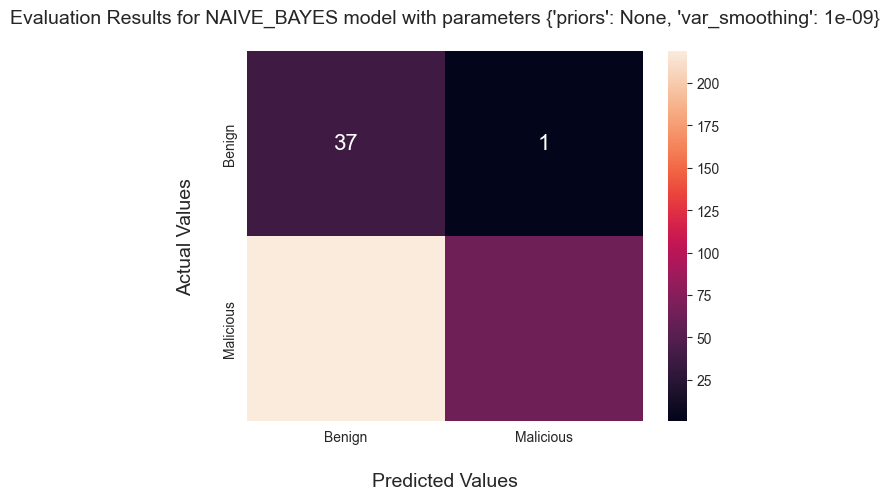

              precision    recall  f1-score   support

           0       0.14      0.97      0.25        38
           1       0.98      0.22      0.36       281

    accuracy                           0.31       319
   macro avg       0.56      0.60      0.31       319
weighted avg       0.88      0.31      0.35       319


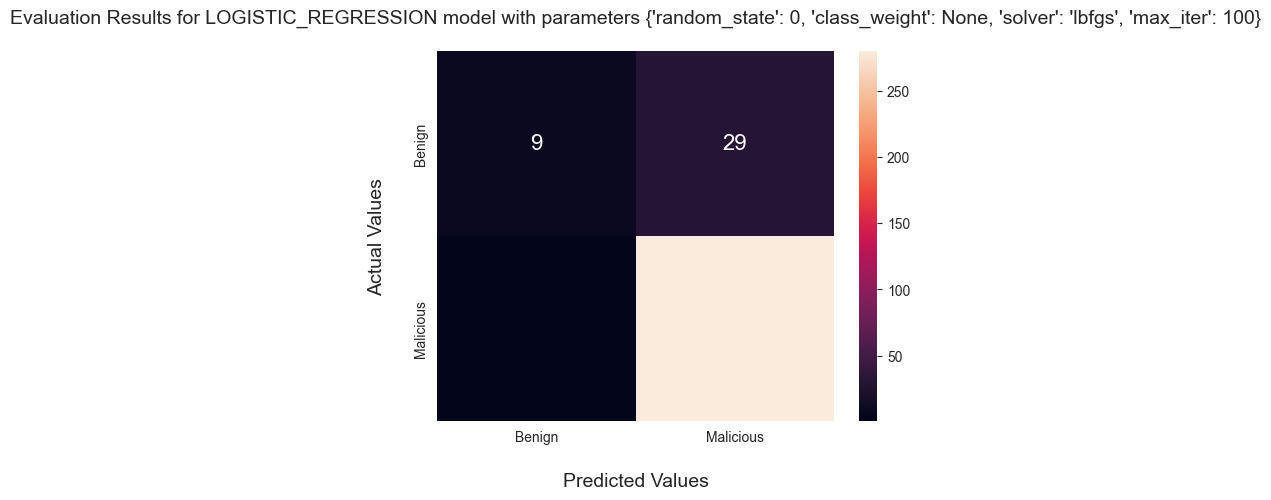

              precision    recall  f1-score   support

           0       0.90      0.24      0.38        38
           1       0.91      1.00      0.95       281

    accuracy                           0.91       319
   macro avg       0.90      0.62      0.66       319
weighted avg       0.91      0.91      0.88       319


In [146]:
for model_name in MODEL_CLASSES_AND_PARAMETERS:
    train_and_evaluate_model(model_name)

In [147]:
clf = LogisticRegression(random_state=0)

best_found_clf = LogisticRegression(random_state=0, solver='lbfgs', penalty='l2')
best_found_clf.fit(X_train, Y_train)

LogisticRegression(random_state=0)

LogisticRegression(random_state=0)
	accuracy: 0.9059561128526645
	precision: 0.99644128113879
	recall: 0.9061488673139159
	f1: 0.9491525423728814
	roc_auc: 0.9030744336569579


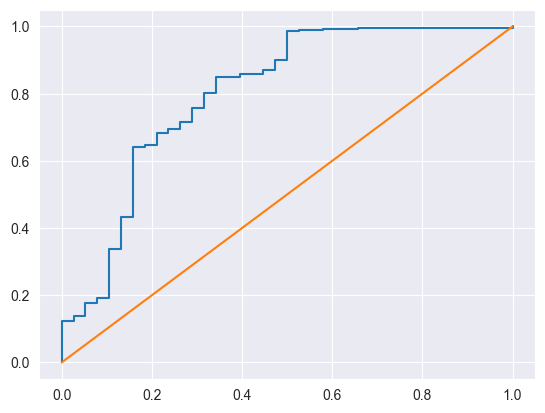

In [160]:

models = [best_found_clf]

ns_probs = [0 for _ in range(len(Y_test))]

for model in models:
    print(model)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1]
    print(f'\taccuracy: {accuracy_score(preds, Y_test)}')
    print(f'\tprecision: {precision_score(preds, Y_test)}')
    print(f'\trecall: {recall_score(preds, Y_test)}')
    print(f'\tf1: {f1_score(preds, Y_test)}')
    print(f'\troc_auc: {roc_auc_score(preds, Y_test)}')
    fpr, tpr, _ = roc_curve(Y_test, probs)
    plt.plot(fpr, tpr)
    fpr, tpr, _ = roc_curve(Y_test, ns_probs)
    plt.plot(fpr, tpr)